In [1]:
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from gensim import corpora, models
import gensim

tokenizer = RegexpTokenizer(r'\w+')

# create English stop words list
en_stop = set(stopwords.words('english'))

# Create p_stemmer of class PorterStemmer
p_stemmer = PorterStemmer()

In [2]:
from dirtojsonl import process_directory

process_directory('c:\\tools\\code\\ResumeAnalytics\\Candidate Resumes', 'candidate.jsonl')
process_directory('c:\\tools\\code\\ResumeAnalytics\\Requisitions', 'other.jsonl')
process_directory('c:\\tools\\code\\ResumeAnalytics\\Target Req', 'target.jsonl')

import json
with open('candidate.jsonl', 'r') as cf, open('target.jsonl', 'r') as tf, open('reqs.jsonl', 'r') as of:
  candidate = [json.loads(line) for line in cf]
  target = [json.loads(line) for line in tf]
  other = [json.loads(line) for line in of]
    
mashed_target = ''
doc_set = []
other_set = []
for t in target:
  doc_set.append(t['content'])
for o in other:
  other_set.append(o['content'])

can_set = []
for c in candidate:
  can_set.append(c['content'])


In [3]:

# list for tokenized documents in loop
texts = []

# loop through document list
for i in doc_set:
    
    # clean and tokenize document string
    raw = i.lower()
    tokens = tokenizer.tokenize(raw)

    # remove stop words from tokens
    stopped_tokens = [i for i in tokens if not i in en_stop]
    
    # stem tokens
    stemmed_tokens = [p_stemmer.stem(i) for i in stopped_tokens]
    
    # add tokens to list
    texts.append(stemmed_tokens)

# Do it again for other list
for i in other_set:
    
    # clean and tokenize document string
    raw = i.lower()
    tokens = tokenizer.tokenize(raw)

    # remove stop words from tokens
    stopped_tokens = [i for i in tokens if not i in en_stop]
    
    # stem tokens
    stemmed_tokens = [p_stemmer.stem(i) for i in stopped_tokens]
    
    # add tokens to list
    texts.append(stemmed_tokens)
    
# turn our tokenized documents into a id <-> term dictionary
dictionary = corpora.Dictionary(texts)

# Remove extreme tokens from the dictionary
dictionary.filter_extremes(no_above=0.85, keep_n=100000)
    
# convert tokenized documents into a document-term matrix
corpus = [dictionary.doc2bow(text) for text in texts]

# Seed the randomness so changes are more easily apparent (best practice)
import numpy
import random
numpy.random.seed(1)
random.seed(1)

# Transform bag of words into TF/IDF
tfidf = gensim.models.tfidfmodel.TfidfModel(corpus, id2word = dictionary, normalize=True)

# generate LDA model
ldamodel = gensim.models.ldamodel.LdaModel(tfidf[corpus], num_topics=175, id2word = dictionary, passes=30)

In [4]:
import math

# Define Jensen Shannon Distance
# Jensen-Shannon Divergence is
# 1/2 (DKL(P||M) + DKL(Q||M))
# Where M = 1/2(P+Q) and
# DKL(X||Y) = Sum(i) of X(i) log X(i)/Y(i)
# Jensen-Shannon Distance is just the square root of the Divergence
def js_distance(p,q):
    import warnings
    warnings.filterwarnings("ignore", category = RuntimeWarning)
    p = numpy.array(p)
    q = numpy.array(q)
    dkl1 = p*numpy.log(2*p/(p+q))
    dkl2 = q*numpy.log(2*q/(p+q))
    dkl1[numpy.isnan(dkl1)] = 0
    dkl2[numpy.isnan(dkl2)] = 0
    div = 0.5*numpy.sum(dkl1+dkl2)
    dist = math.sqrt(div)
    return dist

def doc_similarity(targ, comp):
    d = dict(comp)
    x = []
    y = []
    for topic in targ:
        if topic[0] in d:
            x.append(topic[1])
            y.append(d[topic[0]])
    return js_distance(x, y)

In [5]:
print (ldamodel.print_topics(num_topics = 175, num_words = 3))

[(0, '0.102*win + 0.061*shape + 0.055*competit'), (1, '0.088*web + 0.074*html + 0.063*master'), (2, '0.060*accuraci + 0.049*resourc + 0.035*repositori'), (3, '0.001*practic + 0.001*mcafe + 0.001*question'), (4, '0.059*correspond + 0.040*divis + 0.038*style'), (5, '0.045*invoic + 0.035*fund + 0.034*verifi'), (6, '0.117*pay + 0.034*invoic + 0.030*submit'), (7, '0.119*enforc + 0.078*law + 0.035*next'), (8, '0.001*experienc + 0.001*model + 0.001*script'), (9, '0.060*advisor + 0.010*onboard + 0.010*prime'), (10, '0.051*tcp + 0.047*reliabl + 0.044*site'), (11, '0.013*engin + 0.013*softwar + 0.013*oper'), (12, '0.106*arab + 0.094*util + 0.049*transport'), (13, '0.115*imag + 0.091*sens + 0.090*sensor'), (14, '0.002*item + 0.001*proposit + 0.001*newslett'), (15, '0.070*vision + 0.051*reloc + 0.041*advertis'), (16, '0.182*ea + 0.015*j2ee + 0.014*modern'), (17, '0.100*mena + 0.054*core + 0.053*show'), (18, '0.071*photoshop + 0.043*newslett + 0.035*adob'), (19, '0.080*warfar + 0.057*naval + 0.042*

In [6]:
print (">>>>Target:<<<<\n")
# Get array of target topics
target_topics = []
for i in target:
    raw = i['content'].lower()
    tokens = tokenizer.tokenize(raw)
    stopped_tokens = [i for i in tokens if not i in en_stop]
    stemmed_tokens = [p_stemmer.stem(i) for i in stopped_tokens]
    print (i['name'])
    topics = ldamodel.get_document_topics(dictionary.doc2bow(stemmed_tokens))
    print (topics)
    target_topics.append(topics)
print (target_topics)


>>>>Target:<<<<

Software Engineer.docx
[(1, 0.02911460552798241), (11, 0.3316438785696485), (31, 0.29731285037202582), (51, 0.011771010571419842), (127, 0.043107636800567721), (129, 0.012246224125270929), (163, 0.052821548387696746), (173, 0.19912503933578327)]
[[(1, 0.02911460552798241), (11, 0.3316438785696485), (31, 0.29731285037202582), (51, 0.011771010571419842), (127, 0.043107636800567721), (129, 0.012246224125270929), (163, 0.052821548387696746), (173, 0.19912503933578327)]]


In [7]:
   
print ("\n\n>>>>Other:<<<<\n")
for i in other:
    raw = i['content'].lower()
    tokens = tokenizer.tokenize(raw)
    stopped_tokens = [i for i in tokens if not i in en_stop]
    stemmed_tokens = [p_stemmer.stem(i) for i in stopped_tokens]
    print (i['name'])
    print (ldamodel.get_document_topics(dictionary.doc2bow(stemmed_tokens)))    
    
print ("\n\n>>>>Candidates:<<<<\n")

for i in candidate:
    raw = i['content'].lower()
    tokens = tokenizer.tokenize(raw)
    stopped_tokens = [i for i in tokens if not i in en_stop]
    stemmed_tokens = [p_stemmer.stem(i) for i in stopped_tokens]
    i['distance'] = 0
    for t in target_topics:
        i['distance'] = i['distance'] + doc_similarity(t, ldamodel.get_document_topics(dictionary.doc2bow(stemmed_tokens)))
    # divide to obtain average distance to all target resumes
    # i['distance'] = i['distance'] / len(target_topics) Except this seems to vary by doc
    print (i['name'] + ": " + str(i['distance']))
    print (ldamodel.get_document_topics(dictionary.doc2bow(stemmed_tokens)))




>>>>Other:<<<<

100002 - A/R Bill/Briefing Spc-Professionals-Accountant I
[(6, 0.087958146963533199), (10, 0.013588537444287757), (11, 0.21787576954760682), (31, 0.31659873384228659), (61, 0.012332719436271717), (78, 0.011375174243717626), (80, 0.012438717275633022), (82, 0.02466422802208796), (111, 0.01360409531517804), (154, 0.013411758255778611), (155, 0.011596051113066604), (173, 0.251969195953683)]
100009 - Accountant Lead-Professionals-Accountant IV
[(11, 0.33471977041162676), (31, 0.24837884883085704), (61, 0.02128922166524844), (63, 0.10252689613792076), (120, 0.0231178472022192), (173, 0.20868652502084467)]
100010 - Accountant Mid-Professionals-Accountant II
[(11, 0.26262960054989443), (31, 0.20811409266372397), (63, 0.25304016757570674), (111, 0.012154972400314688), (114, 0.010991421137121468), (173, 0.24068879329228968)]
100011 - Accountant Sr-Professionals-Accountant III
[(11, 0.21243061273530475), (31, 0.31133416735224451), (63, 0.2009734299369472), (77, 0.02268480278815

Aberra Aimen 7494924 Resume.txt: 0.10908639841524014
Agnihotri Vasant 4883545 Resume.txt: 0.06692980920225959
Aravind Neethu 7591941 Resume (003).txt: 0.1454344456957131
Armstrong Mike 6086999 Resume.txt: 0.07317019771034976
Bederu Mariam 6728650 Resume.txt: 0.14180885175000135
BrionnaHuskeyResumeFull (1) (002).txt: 0.07920830508979872
Bruley David 7590965 Resume(003).txt: 0.33433527164960297
Chen John 5261366 Resume.txt: 0.09851522165328941
Chen William 1399420 Resume(003).txt: 0.12872013273825006
Chung Monica 4465479 Resume(003).txt: 0.07019477531587373
Coleman Brad 621556 Resume.txt: 0.08392531826019209
Duda Chris 6196252 Resume.txt: 0.11562208607728874
Dudley Denis 7493280 Resume(003).txt: 0.04157727099708685
FisehaegasiNet(003).txt: 0.10452342524512832
Hamilton Tiffany 5538608 Resume.txt: 0.08315718503894083
Hayes Andrew 6861994 Resume.txt: 0.11546306050305245
Isaac Anderson.txt: 0.13106101577618365
Islam Jannatul 7421017 Resume.txt: 0.07658309496613702
JacksonToomeyResume2016 (00

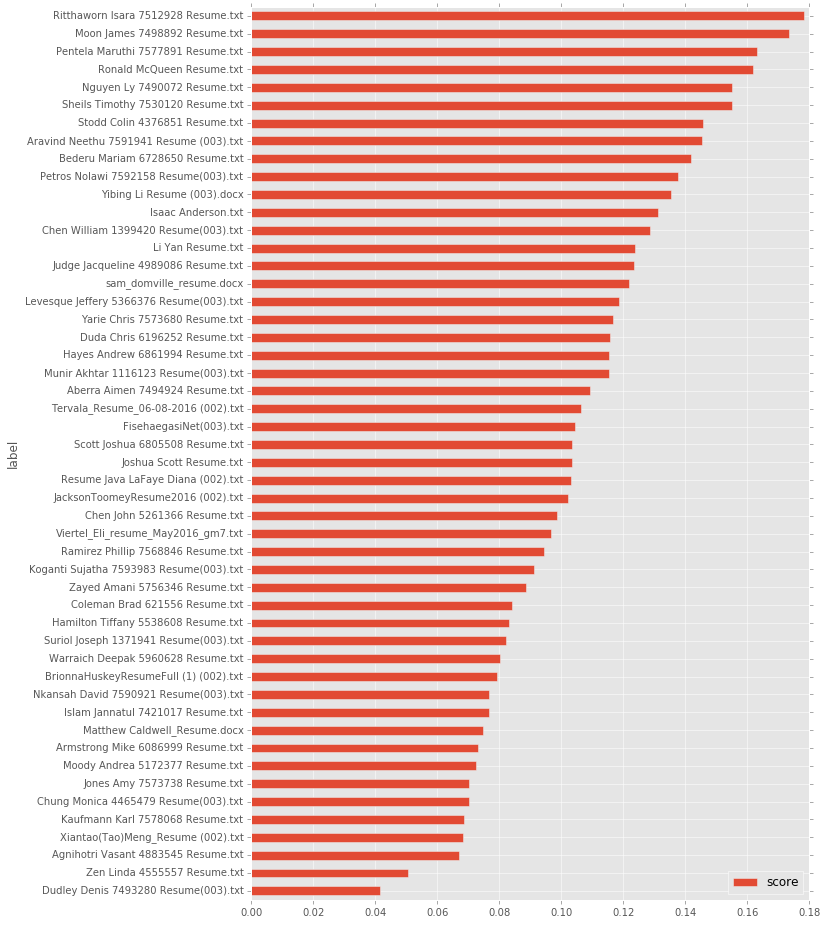

In [8]:
%matplotlib inline
import pandas as pd
import matplotlib
matplotlib.style.use('ggplot')
matplotlib.rcParams['figure.figsize'] = (10.0, 16.0)

result = []
for i in range(len(candidate)):
    print(candidate[i]['name'] + ": " + str(candidate[i]['distance']))
    result.append((candidate[i]['name'], candidate[i]['distance']))
result = sorted(result, key=lambda x: x[1], reverse=False)

df = pd.DataFrame(result, columns=['label', 'score'])
df[:50].plot(kind='barh', x='label', y='score');